Import important parameter

In [1]:
inputsize =19**2
e = 0.05

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 4.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 4*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <10000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
error=10e-11
def u_real(x, y): return np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
def rightf(x, y): return  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)*(np.cos((x + y)/e) + 2) + (3*np.pi*np.cos(3*np.pi*x)*np.sin(5*np.pi*y)*np.sin((x + y)/e))/e + (5*np.pi*np.cos(5*np.pi*y)*np.sin(3*np.pi*x)*np.sin((x + y)/e))/e
def a(x, y): return 2+np.cos((x+y)/e)
sqrtinputsize = int(np.sqrt(inputsize))     
sqrtoutputsize = int(sqrtinputsize/2)
outputsize = int(sqrtoutputsize**2)
h = 1/(sqrtinputsize-1)
H = 1/(sqrtoutputsize-1)
A0 = Poisson(inputsize)
num_levels=2
n=sqrtinputsize
kx = np.zeros([n,n+1])
ky = np.zeros([n+1,n])
for i in range(n):
    for j in range(n+1):
        kx[i][j] = a((j-0.5)*h,i*h)
for i in range(n+1):
    for j in range(n):
        ky[i][j] = a(j*h,(i-0.5)*h)    
A1 = gallery.nonlinearPoisson((n,n), kx, ky)
n = inputsize
linear_gmg = gmg_linear.LinearGMG(A1, max_levels=num_levels)
print("Linear = {}".format(linear_gmg.compute_rho()))
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
Ureal = u_real(X,Y).reshape(inputsize, 1)
Media = a(X,Y)
R = Restriction(inputsize)
P = 4*np.transpose(R)

Linear = 0.19907379527965394


GMM on fine grid

In [5]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, R, s, w, error)

Residual = 16.010111628314966
Interation = 1
Residual = 2.5970403300210063
Interation = 2
Residual = 0.7595162348895053
Interation = 3
Residual = 0.2443789543972215
Interation = 4
Residual = 0.08461857736384522
Interation = 5
Residual = 0.030909845296759917
Interation = 6
Residual = 0.011737277496683603
Interation = 7
Residual = 0.004587293626453187
Interation = 8
Residual = 0.0018327314460042585
Interation = 9
Residual = 0.0007448297725192062
Interation = 10
Residual = 0.00030678103043220054
Interation = 11
Residual = 0.00012769831461489507
Interation = 12
Residual = 5.360141798641545e-05
Interation = 13
Residual = 2.2649657000317194e-05
Interation = 14
Residual = 9.621930852447286e-06
Interation = 15
Residual = 4.105093888040792e-06
Interation = 16
Residual = 1.757458243637825e-06
Interation = 17
Residual = 7.545068719838699e-07
Interation = 18
Residual = 3.246616621629576e-07
Interation = 19
Residual = 1.39961154866652e-07
Interation = 20
Residual = 6.042934839483473e-08
Interation 

Error GMM on fine grid

In [6]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
GMMU = GMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = GMMU - UREAL
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
2.7318218247278017
L2 norm: 
0.1841653445870314
H1 norm: 
2.0189874791799176
Energy norm: 
0.22284227726552658
L2 norm: 
0.3683306891740628
H1 norm: 
0.23226066931079392


Solution

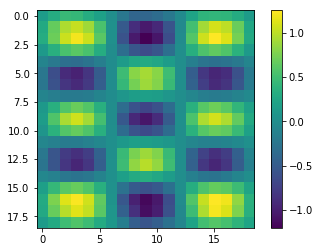

In [7]:
plt.imshow(GMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

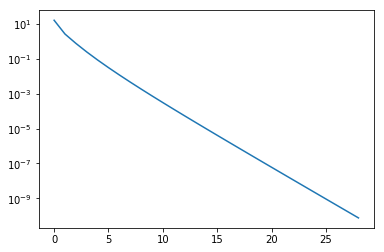

In [8]:
plt.semilogy(GMM_Res)

Radius

In [9]:
GMM_Radius = rho(inputsize,A1.to_full(),4*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.4446947623542016


Global DMM optimization

In [10]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, 
                                                           learning_rate = 1e-4,accept_radius =
                                                           GMM_Radius*10,step_length = 1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.44623425354150803
L = 0.03
rho = 0.4461813230895276
L = 0.04
rho = 0.44612582920932403
L = 0.05
rho = 0.446067978035076
L = 0.060000000000000005
rho = 0.4460079622729524
L = 0.07
rho = 0.4459459620793191
L = 0.08
rho = 0.44588214588392755
L = 0.09
rho = 0.44581667116041757
L = 0.09999999999999999
rho = 0.4457496851466491
L = 0.10999999999999999
rho = 0.4456813255174937
L = 0.11999999999999998
rho = 0.44561172101274465
L = 0.12999999999999998
rho = 0.44554099202279307
L = 0.13999999999999999
rho = 0.4454692511346602
L = 0.15
rho = 0.44539660364090206
L = 0.16
rho = 0.4453231480138009
L = 0.17
rho = 0.445248976347149
L = 0.18000000000000002
rho = 0.44517417476781623
L = 0.19000000000000003
rho = 0.4450988238191692
L = 0.20000000000000004
rho = 0.4450229988182927
L = 0.21000000000000005
rho = 0.4449467701888417
L = 0.22000000000000006
rho = 0.44487020377123976
L = 0.23000000000000007
rho = 0.4447933611118244
L = 0.24000000000000007
rho = 0.4447162997

the 27 steps
rho = 0.43834528837940934
the 28 steps
rho = 0.43829449289736155
the 29 steps
rho = 0.43824370313179467
the 30 steps
rho = 0.43819291908174723
the 31 steps
rho = 0.4381421407462649
the 32 steps
rho = 0.43809136812439986
the 33 steps
rho = 0.4380406012152113
the 34 steps
rho = 0.4379898400177646
the 35 steps
rho = 0.43793908453113173
the 36 steps
rho = 0.4378883347543912
the 37 steps
rho = 0.4378375906866275
the 38 steps
rho = 0.43778685232693093
the 39 steps
rho = 0.43773611967439807
the 40 steps
rho = 0.4376853927281312
the 41 steps
rho = 0.4376346714872384
the 42 steps
rho = 0.4375839559508331
the 43 steps
rho = 0.43753324611803446
the 44 steps
rho = 0.43748254198796693
the 45 steps
rho = 0.43743184355976017
the 46 steps
rho = 0.43738115083254947
the 47 steps
rho = 0.43733046380547447
the 48 steps
rho = 0.4372797824776805
the 49 steps
rho = 0.43722910684831745
the 50 steps
rho = 0.4371784369165402
the 51 steps
rho = 0.4371277726815081
the 52 steps
rho = 0.437077114142385

the 167 steps
rho = 0.4312891815895375
the 168 steps
rho = 0.4312391789164672
the 169 steps
rho = 0.4311891818601695
the 170 steps
rho = 0.4311391904200613
the 171 steps
rho = 0.43108920459556044
the 172 steps
rho = 0.43103922438608533
the 173 steps
rho = 0.4309892497910556
the 174 steps
rho = 0.4309392808098914
the 175 steps
rho = 0.4308893174420144
the 176 steps
rho = 0.43083935968684656
the 177 steps
rho = 0.4307894075438113
the 178 steps
rho = 0.43073946101233196
the 179 steps
rho = 0.4306895200918336
the 180 steps
rho = 0.43063958478174186
the 181 steps
rho = 0.43058965508148306
the 182 steps
rho = 0.43053973099048465
the 183 steps
rho = 0.4304898125081747
the 184 steps
rho = 0.430439899633982
the 185 steps
rho = 0.4303899923673362
the 186 steps
rho = 0.43034009070766804
the 187 steps
rho = 0.4302901946544085
the 188 steps
rho = 0.43024030420698994
the 189 steps
rho = 0.43019041936484487
the 190 steps
rho = 0.43014054012740705
the 191 steps
rho = 0.4300906664941109
the 192 steps
r

the 306 steps
rho = 0.4243924358336987
the 307 steps
rho = 0.4243432085976484
the 308 steps
rho = 0.4242939869032692
the 309 steps
rho = 0.42424477075005
the 310 steps
rho = 0.4241955601374794
the 311 steps
rho = 0.42414635506504633
the 312 steps
rho = 0.4240971555322402
the 313 steps
rho = 0.42404796153855034
the 314 steps
rho = 0.42399877308346684
the 315 steps
rho = 0.4239495901664797
the 316 steps
rho = 0.4239004127870791
the 317 steps
rho = 0.4238512409447557
the 318 steps
rho = 0.42380207463900016
the 319 steps
rho = 0.42375291386930375
the 320 steps
rho = 0.4237037586351577
the 321 steps
rho = 0.42365460893605345
the 322 steps
rho = 0.423605464771483
the 323 steps
rho = 0.42355632614093824
the 324 steps
rho = 0.4235071930439114
the 325 steps
rho = 0.4234580654798952
the 326 steps
rho = 0.4234089434483821
the 327 steps
rho = 0.4233598269488652
the 328 steps
rho = 0.4233107159808377
the 329 steps
rho = 0.4232616105437931
the 330 steps
rho = 0.42321251063722487
the 331 steps
rho = 

the 446 steps
rho = 0.4175543176523768
the 447 steps
rho = 0.41750586136636425
the 448 steps
rho = 0.4174574105522778
the 449 steps
rho = 0.41740896520962883
the 450 steps
rho = 0.4173605253379287
the 451 steps
rho = 0.417312090936689
the 452 steps
rho = 0.41726366200542103
the 453 steps
rho = 0.4172152385436365
the 454 steps
rho = 0.4171668205508473
the 455 steps
rho = 0.4171184080265651
the 456 steps
rho = 0.4170700009703018
the 457 steps
rho = 0.41702159938156924
the 458 steps
rho = 0.4169732032598797
the 459 steps
rho = 0.4169248126047452
the 460 steps
rho = 0.41687642741567793
the 461 steps
rho = 0.41682804769219034
the 462 steps
rho = 0.4167796734337947
the 463 steps
rho = 0.41673130464000346
the 464 steps
rho = 0.41668294131032924
the 465 steps
rho = 0.4166345834442847
the 466 steps
rho = 0.41658623104138237
the 467 steps
rho = 0.41653788410113524
the 468 steps
rho = 0.41648954262305593
the 469 steps
rho = 0.41644120660665757
the 470 steps
rho = 0.4163928760514531
the 471 steps


the 585 steps
rho = 0.4108711621563276
the 586 steps
rho = 0.4108234618104486
the 587 steps
rho = 0.41077576686915335
the 588 steps
rho = 0.41072807733196004
the 589 steps
rho = 0.41068039319838684
the 590 steps
rho = 0.4106327144679519
the 591 steps
rho = 0.41058504114017363
the 592 steps
rho = 0.4105373732145701
the 593 steps
rho = 0.4104897106906597
the 594 steps
rho = 0.4104420535679607
the 595 steps
rho = 0.4103944018459914
the 596 steps
rho = 0.41034675552427013
the 597 steps
rho = 0.41029911460231505
the 598 steps
rho = 0.4102514790796449
the 599 steps
rho = 0.41020384895577766
the 600 steps
rho = 0.41015622423023185
the 601 steps
rho = 0.41010860490252576
the 602 steps
rho = 0.4100609909721781
the 603 steps
rho = 0.4100133824387069
the 604 steps
rho = 0.40996577930163086
the 605 steps
rho = 0.4099181815604684
the 606 steps
rho = 0.4098705892147379
the 607 steps
rho = 0.4098230022639579
the 608 steps
rho = 0.4097754207076468
the 609 steps
rho = 0.40972784454532307
the 610 steps


the 724 steps
rho = 0.4042924385563994
the 725 steps
rho = 0.40424548482995987
the 726 steps
rho = 0.4041985364411761
the 727 steps
rho = 0.40415159338956586
the 728 steps
rho = 0.40410465567464743
the 729 steps
rho = 0.40405772329593853
the 730 steps
rho = 0.40401079625295727
the 731 steps
rho = 0.40396387454522165
the 732 steps
rho = 0.4039169581722495
the 733 steps
rho = 0.4038700471335588
the 734 steps
rho = 0.40382314142866726
the 735 steps
rho = 0.403776241057093
the 736 steps
rho = 0.4037293460183537
the 737 steps
rho = 0.4036824563119673
the 738 steps
rho = 0.4036355719374516
the 739 steps
rho = 0.4035886928943243
the 740 steps
rho = 0.4035418191821034
the 741 steps
rho = 0.4034949508003065
the 742 steps
rho = 0.4034480877484514
the 743 steps
rho = 0.4034012300260558
the 744 steps
rho = 0.40335437763263754
the 745 steps
rho = 0.40330753056771407
the 746 steps
rho = 0.4032606888308032
the 747 steps
rho = 0.40321385242142244
the 748 steps
rho = 0.40316702133908966
the 749 steps
r

the 862 steps
rho = 0.39786307432131324
the 863 steps
rho = 0.39781685262599087
the 864 steps
rho = 0.3977706362015966
the 865 steps
rho = 0.3977244250476449
the 866 steps
rho = 0.3976782191636504
the 867 steps
rho = 0.3976320185491278
the 868 steps
rho = 0.39758582320359137
the 869 steps
rho = 0.3975396331265558
the 870 steps
rho = 0.3974934483175354
the 871 steps
rho = 0.39744726877604475
the 872 steps
rho = 0.39740109450159805
the 873 steps
rho = 0.39735492549370993
the 874 steps
rho = 0.39730876175189456
the 875 steps
rho = 0.3972626032756663
the 876 steps
rho = 0.3972164500645394
the 877 steps
rho = 0.3971703021180281
the 878 steps
rho = 0.3971241594356467
the 879 steps
rho = 0.3970780220169094
the 880 steps
rho = 0.39703188986133026
the 881 steps
rho = 0.39698576296842353
the 882 steps
rho = 0.3969396413377032
the 883 steps
rho = 0.3968935249686835
the 884 steps
rho = 0.3968474138608784
the 885 steps
rho = 0.39680130801380187
the 886 steps
rho = 0.3967552074269679
the 887 steps
r

the 1001 steps
rho = 0.3914885991186713
the 1002 steps
rho = 0.391443105414559
the 1003 steps
rho = 0.39139761691364183
the 1004 steps
rho = 0.39135213361543086
the 1005 steps
rho = 0.3913066555194372
the 1006 steps
rho = 0.39126118262517195
the 1007 steps
rho = 0.39121571493214596
the 1008 steps
rho = 0.3911702524398705
the 1009 steps
rho = 0.39112479514785653
the 1010 steps
rho = 0.391079343055615
the 1011 steps
rho = 0.391033896162657
the 1012 steps
rho = 0.39098845446849323
the 1013 steps
rho = 0.39094301797263503
the 1014 steps
rho = 0.390897586674593
the 1015 steps
rho = 0.3908521605738784
the 1016 steps
rho = 0.3908067396700018
the 1017 steps
rho = 0.39076132396247437
the 1018 steps
rho = 0.390715913450807
the 1019 steps
rho = 0.3906705081345105
the 1020 steps
rho = 0.3906251080130956
the 1021 steps
rho = 0.39057971308607337
the 1022 steps
rho = 0.39053432335295457
the 1023 steps
rho = 0.39048893881325
the 1024 steps
rho = 0.3904435594664707
the 1025 steps
rho = 0.39039818531212

the 1137 steps
rho = 0.38534902010697863
the 1138 steps
rho = 0.3853042295468476
the 1139 steps
rho = 0.38525944412340696
the 1140 steps
rho = 0.385214663836169
the 1141 steps
rho = 0.38516988868464597
the 1142 steps
rho = 0.3851251186683502
the 1143 steps
rho = 0.38508035378679406
the 1144 steps
rho = 0.38503559403949006
the 1145 steps
rho = 0.38499083942595064
the 1146 steps
rho = 0.3849460899456882
the 1147 steps
rho = 0.3849013455982155
the 1148 steps
rho = 0.384856606383045
the 1149 steps
rho = 0.3848118722996895
the 1150 steps
rho = 0.38476714334766154
the 1151 steps
rho = 0.38472241952647407
the 1152 steps
rho = 0.38467770083563985
the 1153 steps
rho = 0.38463298727467177
the 1154 steps
rho = 0.3845882788430827
the 1155 steps
rho = 0.3845435755403858
the 1156 steps
rho = 0.384498877366094
the 1157 steps
rho = 0.38445418431972045
the 1158 steps
rho = 0.38440949640077815
the 1159 steps
rho = 0.38436481360878044
the 1160 steps
rho = 0.3843201359432407
the 1161 steps
rho = 0.3842754

the 1273 steps
rho = 0.3793044596748327
the 1274 steps
rho = 0.37926036325789547
the 1275 steps
rho = 0.3792162719121271
the 1276 steps
rho = 0.37917218563705596
the 1277 steps
rho = 0.37912810443221084
the 1278 steps
rho = 0.37908402829712023
the 1279 steps
rho = 0.37903995723131334
the 1280 steps
rho = 0.3789958912343194
the 1281 steps
rho = 0.3789518303056678
the 1282 steps
rho = 0.37890777444488843
the 1283 steps
rho = 0.3788637236515112
the 1284 steps
rho = 0.3788196779250664
the 1285 steps
rho = 0.37877563726508434
the 1286 steps
rho = 0.3787316016710958
the 1287 steps
rho = 0.37868757114263185
the 1288 steps
rho = 0.3786435456792236
the 1289 steps
rho = 0.3785995252804024
the 1290 steps
rho = 0.37855550994570025
the 1291 steps
rho = 0.378511499674649
the 1292 steps
rho = 0.3784674944667809
the 1293 steps
rho = 0.3784234943216285
the 1294 steps
rho = 0.3783794992387245
the 1295 steps
rho = 0.3783355092176019
the 1296 steps
rho = 0.3782915242577942
the 1297 steps
rho = 0.378247544

the 1410 steps
rho = 0.3733103000633115
the 1411 steps
rho = 0.37326689413899045
the 1412 steps
rho = 0.37322349322467724
the 1413 steps
rho = 0.373180097319966
the 1414 steps
rho = 0.3731367064244515
the 1415 steps
rho = 0.3730933205377299
the 1416 steps
rho = 0.37304993965939787
the 1417 steps
rho = 0.3730065637890531
the 1418 steps
rho = 0.3729631929262945
the 1419 steps
rho = 0.37291982707072163
the 1420 steps
rho = 0.3728764662219353
the 1421 steps
rho = 0.37283311037953715
the 1422 steps
rho = 0.37278975954313004
the 1423 steps
rho = 0.37274641371231765
the 1424 steps
rho = 0.3727030728867047
the 1425 steps
rho = 0.37265973706589706
the 1426 steps
rho = 0.3726164062495018
the 1427 steps
rho = 0.3725730804371269
the 1428 steps
rho = 0.37252975962838136
the 1429 steps
rho = 0.37248644382287555
the 1430 steps
rho = 0.3724431330202207
the 1431 steps
rho = 0.37239982722002957
the 1432 steps
rho = 0.3723565264219156
the 1433 steps
rho = 0.3723132306254937
the 1434 steps
rho = 0.3722699

the 1546 steps
rho = 0.3674529397279662
the 1547 steps
rho = 0.3674102121481621
the 1548 steps
rho = 0.36736748954469567
the 1549 steps
rho = 0.36732477191774626
the 1550 steps
rho = 0.36728205926750956
the 1551 steps
rho = 0.3672393515941974
the 1552 steps
rho = 0.3671966488980393
the 1553 steps
rho = 0.36715395117928196
the 1554 steps
rho = 0.3671112584381905
the 1555 steps
rho = 0.3670685706750488
the 1556 steps
rho = 0.36702588789015994
the 1557 steps
rho = 0.3669832100838474
the 1558 steps
rho = 0.36694053725645465
the 1559 steps
rho = 0.366897869408347
the 1560 steps
rho = 0.3668552065399115
the 1561 steps
rho = 0.3668125486515577
the 1562 steps
rho = 0.36676989574371877
the 1563 steps
rho = 0.366727247816852
the 1564 steps
rho = 0.36668460487143945
the 1565 steps
rho = 0.36664196690798895
the 1566 steps
rho = 0.366599333927035
the 1567 steps
rho = 0.3665567059291393
the 1568 steps
rho = 0.36651408291489207
the 1569 steps
rho = 0.36647146488491295
the 1570 steps
rho = 0.366428851

the 1683 steps
rho = 0.36164644575317645
the 1684 steps
rho = 0.3616044337106722
the 1685 steps
rho = 0.3615624279178281
the 1686 steps
rho = 0.3615204284202384
the 1687 steps
rho = 0.36147843526509693
the 1688 steps
rho = 0.36143644850125256
the 1689 steps
rho = 0.3613944681792668
the 1690 steps
rho = 0.3613524943514737
the 1691 steps
rho = 0.36131052707204164
the 1692 steps
rho = 0.36126856639703675
the 1693 steps
rho = 0.36122661238448955
the 1694 steps
rho = 0.3611846650944631
the 1695 steps
rho = 0.3611427245891234
the 1696 steps
rho = 0.361100790932813
the 1697 steps
rho = 0.36105886419212635
the 1698 steps
rho = 0.36101694443598803
the 1699 steps
rho = 0.3609750317357341
the 1700 steps
rho = 0.3609331261651949
the 1701 steps
rho = 0.36089122780078264
the 1702 steps
rho = 0.3608493367215803
the 1703 steps
rho = 0.360807453009434
the 1704 steps
rho = 0.3607655767490495
the 1705 steps
rho = 0.3607237080280908
the 1706 steps
rho = 0.360681846937282
the 1707 steps
rho = 0.36063999357

the 1820 steps
rho = 0.35604492460357406
the 1821 steps
rho = 0.356007375848882
the 1822 steps
rho = 0.3559699538762842
the 1823 steps
rho = 0.35593266217220215
the 1824 steps
rho = 0.35589550429754946
the 1825 steps
rho = 0.35585848388768837
the 1826 steps
rho = 0.3558216046522604
the 1827 steps
rho = 0.3557848703748823
the 1828 steps
rho = 0.3557482849127
the 1829 steps
rho = 0.35571185219579105
the 1830 steps
rho = 0.35567557622640894
the 1831 steps
rho = 0.35563946107805866
the 1832 steps
rho = 0.35560351089439596
the 1833 steps
rho = 0.3555677298879414
the 1834 steps
rho = 0.35553212233860115
the 1835 steps
rho = 0.35549669259198463
the 1836 steps
rho = 0.35546144505751204
the 1837 steps
rho = 0.355426384206302
the 1838 steps
rho = 0.3553915145688333
the 1839 steps
rho = 0.35535684073237034
the 1840 steps
rho = 0.3553223673381469
the 1841 steps
rho = 0.35528809907830083
the 1842 steps
rho = 0.3552540406925519
the 1843 steps
rho = 0.35522019696461876
the 1844 steps
rho = 0.35518657

the 1957 steps
rho = 0.3533357152957901
the 1958 steps
rho = 0.35333228132080274
the 1959 steps
rho = 0.35332891825214197
the 1960 steps
rho = 0.35332562323821337
the 1961 steps
rho = 0.35332239352253947
the 1962 steps
rho = 0.3533192264420025
the 1963 steps
rho = 0.3533161194250147
the 1964 steps
rho = 0.35331306998962314
the 1965 steps
rho = 0.3533100757415621
the 1966 steps
rho = 0.35330713437225847
the 1967 steps
rho = 0.35330424365680047
the 1968 steps
rho = 0.3533014014518781
the 1969 steps
rho = 0.3532986056937007
the 1970 steps
rho = 0.3532958543959005
the 1971 steps
rho = 0.35329314564742753
the 1972 steps
rho = 0.3532904776104424
the 1973 steps
rho = 0.3532878485182121
the 1974 steps
rho = 0.35328525667301347
the 1975 steps
rho = 0.35328270044405063
the 1976 steps
rho = 0.35328017826538904
the 1977 steps
rho = 0.3532776886339099
the 1978 steps
rho = 0.35327523010729034
the 1979 steps
rho = 0.35327280130200983
the 1980 steps
rho = 0.35327040089138834
the 1981 steps
rho = 0.353

the 2094 steps
rho = 0.3530522553161663
the 2095 steps
rho = 0.35305045608803426
the 2096 steps
rho = 0.3530486572743156
the 2097 steps
rho = 0.3530468588704011
the 2098 steps
rho = 0.3530450608718782
the 2099 steps
rho = 0.3530432632745213
the 2100 steps
rho = 0.35304146607428255
the 2101 steps
rho = 0.353039669267283
the 2102 steps
rho = 0.35303787284980354
the 2103 steps
rho = 0.3530360768182772
the 2104 steps
rho = 0.35303428116928204
the 2105 steps
rho = 0.3530324858995332
the 2106 steps
rho = 0.35303069100587625
the 2107 steps
rho = 0.3530288964852809
the 2108 steps
rho = 0.353027102334835
the 2109 steps
rho = 0.3530253085517376
the 2110 steps
rho = 0.35302351513329483
the 2111 steps
rho = 0.3530217220769139
the 2112 steps
rho = 0.3530199293800976
the 2113 steps
rho = 0.35301813704044077
the 2114 steps
rho = 0.3530163450556247
the 2115 steps
rho = 0.3530145534234134
the 2116 steps
rho = 0.35301276214164945
the 2117 steps
rho = 0.35301097120825004
the 2118 steps
rho = 0.3530091806

the 2231 steps
rho = 0.35280880043977086
the 2232 steps
rho = 0.35280704287811276
the 2233 steps
rho = 0.35280528557038837
the 2234 steps
rho = 0.3528035285161071
the 2235 steps
rho = 0.35280177171477933
the 2236 steps
rho = 0.3528000151659173
the 2237 steps
rho = 0.35279825886903465
the 2238 steps
rho = 0.35279650282364644
the 2239 steps
rho = 0.3527947470292694
the 2240 steps
rho = 0.3527929914854214
the 2241 steps
rho = 0.35279123619162206
the 2242 steps
rho = 0.35278948114739217
the 2243 steps
rho = 0.35278772635225425
the 2244 steps
rho = 0.3527859718057318
the 2245 steps
rho = 0.35278421750735
the 2246 steps
rho = 0.35278246345663533
the 2247 steps
rho = 0.35278070965311575
the 2248 steps
rho = 0.3527789560963204
the 2249 steps
rho = 0.3527772027857797
the 2250 steps
rho = 0.35277544972102565
the 2251 steps
rho = 0.3527736969015914
the 2252 steps
rho = 0.35277194432701137
the 2253 steps
rho = 0.35277019199682147
the 2254 steps
rho = 0.35276843991055873
the 2255 steps
rho = 0.3527

the 2368 steps
rho = 0.3525701922053484
the 2369 steps
rho = 0.3525684653763954
the 2370 steps
rho = 0.35256673874512795
the 2371 steps
rho = 0.35256501231120685
the 2372 steps
rho = 0.35256328607429416
the 2373 steps
rho = 0.35256156003405253
the 2374 steps
rho = 0.35255983419014597
the 2375 steps
rho = 0.3525581085422393
the 2376 steps
rho = 0.35255638308999826
the 2377 steps
rho = 0.3525546578330898
the 2378 steps
rho = 0.3525529327711819
the 2379 steps
rho = 0.35255120790394334
the 2380 steps
rho = 0.3525494832310441
the 2381 steps
rho = 0.35254775875215505
the 2382 steps
rho = 0.35254603446694815
the 2383 steps
rho = 0.35254431037509615
the 2384 steps
rho = 0.35254258647627323
the 2385 steps
rho = 0.35254086277015434
the 2386 steps
rho = 0.3525391392564153
the 2387 steps
rho = 0.35253741593473326
the 2388 steps
rho = 0.3525356928047861
the 2389 steps
rho = 0.3525339698662529
the 2390 steps
rho = 0.3525322471188138
the 2391 steps
rho = 0.3525305245621499
the 2392 steps
rho = 0.3525

the 2505 steps
rho = 0.3523353306760035
the 2506 steps
rho = 0.35233362821080866
the 2507 steps
rho = 0.3523319259068331
the 2508 steps
rho = 0.3523302237638918
the 2509 steps
rho = 0.3523285217818006
the 2510 steps
rho = 0.3523268199603771
the 2511 steps
rho = 0.3523251182994401
the 2512 steps
rho = 0.3523234167988096
the 2513 steps
rho = 0.3523217154583071
the 2514 steps
rho = 0.352320014277755
the 2515 steps
rho = 0.3523183132569776
the 2516 steps
rho = 0.3523166123958001
the 2517 steps
rho = 0.3523149116940492
the 2518 steps
rho = 0.35231321115155295
the 2519 steps
rho = 0.35231151076814066
the 2520 steps
rho = 0.352309810543643
the 2521 steps
rho = 0.3523081104778919
the 2522 steps
rho = 0.3523064105707208
the 2523 steps
rho = 0.35230471082196446
the 2524 steps
rho = 0.35230301123145885
the 2525 steps
rho = 0.3523013117990414
the 2526 steps
rho = 0.35229961252455094
the 2527 steps
rho = 0.3522979134078274
the 2528 steps
rho = 0.3522962144487125
the 2529 steps
rho = 0.3522945156470

the 2642 steps
rho = 0.3521035367975065
the 2643 steps
rho = 0.35210185528864296
the 2644 steps
rho = 0.3521001739292309
the 2645 steps
rho = 0.35209849271929694
the 2646 steps
rho = 0.3520968116588695
the 2647 steps
rho = 0.3520951307479792
the 2648 steps
rho = 0.3520934499866579
the 2649 steps
rho = 0.3520917693749395
the 2650 steps
rho = 0.35209008891286014
the 2651 steps
rho = 0.35208840860045715
the 2652 steps
rho = 0.35208672843777006
the 2653 steps
rho = 0.35208504842484034
the 2654 steps
rho = 0.3520833685617109
the 2655 steps
rho = 0.3520816888484269
the 2656 steps
rho = 0.35208000928503524
the 2657 steps
rho = 0.35207832987158466
the 2658 steps
rho = 0.3520766506081256
the 2659 steps
rho = 0.3520749714947105
the 2660 steps
rho = 0.3520732925313939
the 2661 steps
rho = 0.35207161371823187
the 2662 steps
rho = 0.35206993505528256
the 2663 steps
rho = 0.35206825654260576
the 2664 steps
rho = 0.35206657818026355
the 2665 steps
rho = 0.35206489996831947
the 2666 steps
rho = 0.3520

the 2779 steps
rho = 0.351874600553717
the 2780 steps
rho = 0.3518729405856509
the 2781 steps
rho = 0.35187128078927915
the 2782 steps
rho = 0.35186962116491416
the 2783 steps
rho = 0.35186796171287044
the 2784 steps
rho = 0.3518663024334648
the 2785 steps
rho = 0.35186464332701667
the 2786 steps
rho = 0.3518629843938478
the 2787 steps
rho = 0.35186132563428185
the 2788 steps
rho = 0.35185966704864535
the 2789 steps
rho = 0.351858008637267
the 2790 steps
rho = 0.3518563504004779
the 2791 steps
rho = 0.3518546923386114
the 2792 steps
rho = 0.3518530344520034
the 2793 steps
rho = 0.35185137674099193
the 2794 steps
rho = 0.35184971920591757
the 2795 steps
rho = 0.3518480618471234
the 2796 steps
rho = 0.3518464046649546
the 2797 steps
rho = 0.351844747659759
the 2798 steps
rho = 0.3518430908318865
the 2799 steps
rho = 0.35184143418168967
the 2800 steps
rho = 0.35183977770952346
the 2801 steps
rho = 0.35183812141574494
the 2802 steps
rho = 0.351836465300714
the 2803 steps
rho = 0.3518348093

the 2915 steps
rho = 0.35165058205760263
the 2916 steps
rho = 0.35164894930516666
the 2917 steps
rho = 0.3516473167894965
the 2918 steps
rho = 0.35164568451124595
the 2919 steps
rho = 0.3516440524710708
the 2920 steps
rho = 0.35164242066963
the 2921 steps
rho = 0.3516407891075847
the 2922 steps
rho = 0.3516391577855988
the 2923 steps
rho = 0.351637526704339
the 2924 steps
rho = 0.3516358958644745
the 2925 steps
rho = 0.35163426526667707
the 2926 steps
rho = 0.351632634911621
the 2927 steps
rho = 0.3516310047999833
the 2928 steps
rho = 0.3516293749324437
the 2929 steps
rho = 0.35162774530968444
the 2930 steps
rho = 0.3516261159323903
the 2931 steps
rho = 0.3516244868012487
the 2932 steps
rho = 0.35162285791694986
the 2933 steps
rho = 0.3516212292801864
the 2934 steps
rho = 0.35161960089165356
the 2935 steps
rho = 0.3516179727520494
the 2936 steps
rho = 0.3516163448620744
the 2937 steps
rho = 0.35161471722243154
the 2938 steps
rho = 0.351613089833827
the 2939 steps
rho = 0.35161146269696

the 3051 steps
rho = 0.3514310046840924
the 3052 steps
rho = 0.35142941119528814
the 3053 steps
rho = 0.35142781805581547
the 3054 steps
rho = 0.3514262252666737
the 3055 steps
rho = 0.35142463282886394
the 3056 steps
rho = 0.35142304074339
the 3057 steps
rho = 0.35142144901125794
the 3058 steps
rho = 0.35141985763347633
the 3059 steps
rho = 0.3514182666110561
the 3060 steps
rho = 0.3514166759450102
the 3061 steps
rho = 0.3514150856363542
the 3062 steps
rho = 0.35141349568610625
the 3063 steps
rho = 0.35141190609528633
the 3064 steps
rho = 0.351410316864917
the 3065 steps
rho = 0.35140872799602335
the 3066 steps
rho = 0.35140713948963237
the 3067 steps
rho = 0.3514055513467738
the 3068 steps
rho = 0.35140396356847936
the 3069 steps
rho = 0.3514023761557833
the 3070 steps
rho = 0.3514007891097222
the 3071 steps
rho = 0.3513992024313347
the 3072 steps
rho = 0.3513976161216621
the 3073 steps
rho = 0.3513960301817477
the 3074 steps
rho = 0.3513944446126373
the 3075 steps
rho = 0.3513928594

the 3188 steps
rho = 0.3512164016557995
the 3189 steps
rho = 0.3512148662674787
the 3190 steps
rho = 0.35121333138566346
the 3191 steps
rho = 0.3512117970116378
the 3192 steps
rho = 0.3512102631466873
the 3193 steps
rho = 0.3512087297920996
the 3194 steps
rho = 0.35120719694916397
the 3195 steps
rho = 0.35120566461917135
the 3196 steps
rho = 0.3512041328034149
the 3197 steps
rho = 0.3512026015031892
the 3198 steps
rho = 0.3512010707197906
the 3199 steps
rho = 0.3511995404545175
the 3200 steps
rho = 0.35119801070866985
the 3201 steps
rho = 0.3511964814835495
the 3202 steps
rho = 0.35119495278046
the 3203 steps
rho = 0.3511934246007067
the 3204 steps
rho = 0.3511918969455967
the 3205 steps
rho = 0.3511903698164389
the 3206 steps
rho = 0.3511888432145441
the 3207 steps
rho = 0.3511873171412246
the 3208 steps
rho = 0.3511857915977946
the 3209 steps
rho = 0.35118426658557
the 3210 steps
rho = 0.35118274210586864
the 3211 steps
rho = 0.35118121816000997
the 3212 steps
rho = 0.351179694749315

the 3324 steps
rho = 0.3510127892516669
the 3325 steps
rho = 0.3510113352677638
the 3326 steps
rho = 0.35100988198170996
the 3327 steps
rho = 0.3510084293950534
the 3328 steps
rho = 0.35100697750934495
the 3329 steps
rho = 0.35100552632613835
the 3330 steps
rho = 0.35100407584698956
the 3331 steps
rho = 0.3510026260734573
the 3332 steps
rho = 0.35100117700710315
the 3333 steps
rho = 0.35099972864949147
the 3334 steps
rho = 0.35099828100218905
the 3335 steps
rho = 0.35099683406676585
the 3336 steps
rho = 0.3509953878447943
the 3337 steps
rho = 0.35099394233784975
the 3338 steps
rho = 0.35099249754751055
the 3339 steps
rho = 0.35099105347535764
the 3340 steps
rho = 0.3509896101229752
the 3341 steps
rho = 0.35098816749194994
the 3342 steps
rho = 0.3509867255838718
the 3343 steps
rho = 0.3509852844003336
the 3344 steps
rho = 0.35098384394293114
the 3345 steps
rho = 0.3509824042132634
the 3346 steps
rho = 0.35098096521293204
the 3347 steps
rho = 0.3509795269435421
the 3348 steps
rho = 0.350

the 3460 steps
rho = 0.3508221351346444
the 3461 steps
rho = 0.3508207917896537
the 3462 steps
rho = 0.3508194493920328
the 3463 steps
rho = 0.3508181079440833
the 3464 steps
rho = 0.3508167674481171
the 3465 steps
rho = 0.3508154279064573
the 3466 steps
rho = 0.3508140893214376
the 3467 steps
rho = 0.35081275169540277
the 3468 steps
rho = 0.3508114150307086
the 3469 steps
rho = 0.3508100793297224
the 3470 steps
rho = 0.35080874459482275
the 3471 steps
rho = 0.3508074108283994
the 3472 steps
rho = 0.3508060780328541
the 3473 steps
rho = 0.3508047462106003
the 3474 steps
rho = 0.3508034153640633
the 3475 steps
rho = 0.35080208549568037
the 3476 steps
rho = 0.35080075660790094
the 3477 steps
rho = 0.35079942870318664
the 3478 steps
rho = 0.3507981017840118
the 3479 steps
rho = 0.350796775852863
the 3480 steps
rho = 0.3507954509122396
the 3481 steps
rho = 0.3507941269646539
the 3482 steps
rho = 0.3507928040126311
the 3483 steps
rho = 0.35079148205870947
the 3484 steps
rho = 0.350790161105

the 3596 steps
rho = 0.3506492806360426
the 3597 steps
rho = 0.35064809381763
the 3598 steps
rho = 0.35064690842898394
the 3599 steps
rho = 0.3506457244756961
the 3600 steps
rho = 0.3506445419634047
the 3601 steps
rho = 0.3506433608977941
the 3602 steps
rho = 0.3506421812845962
the 3603 steps
rho = 0.35064100312959035
the 3604 steps
rho = 0.350639826438604
the 3605 steps
rho = 0.35063865121751336
the 3606 steps
rho = 0.35063747747224383
the 3607 steps
rho = 0.3506363052087707
the 3608 steps
rho = 0.3506351344331191
the 3609 steps
rho = 0.35063396515136513
the 3610 steps
rho = 0.3506327973696364
the 3611 steps
rho = 0.350631631094112
the 3612 steps
rho = 0.35063046633102374
the 3613 steps
rho = 0.35062930308665635
the 3614 steps
rho = 0.35062814136734793
the 3615 steps
rho = 0.350626981179491
the 3616 steps
rho = 0.3506258225295325
the 3617 steps
rho = 0.3506246654239747
the 3618 steps
rho = 0.35062350986937574
the 3619 steps
rho = 0.3506223558723504
the 3620 steps
rho = 0.3506212034395

the 3732 steps
rho = 0.3505041489425277
the 3733 steps
rho = 0.3505032359775081
the 3734 steps
rho = 0.35050232592601804
the 3735 steps
rho = 0.35050141880764957
the 3736 steps
rho = 0.3505005146421899
the 3737 steps
rho = 0.35049961344962466
the 3738 steps
rho = 0.3504987152501388
the 3739 steps
rho = 0.35049782006411967
the 3740 steps
rho = 0.3504969279121585
the 3741 steps
rho = 0.35049603881505315
the 3742 steps
rho = 0.35049515279380966
the 3743 steps
rho = 0.3504942698696452
the 3744 steps
rho = 0.35049339006398955
the 3745 steps
rho = 0.350492513398488
the 3746 steps
rho = 0.3504916398950034
the 3747 steps
rho = 0.35049076957561814
the 3748 steps
rho = 0.35048990246263695
the 3749 steps
rho = 0.35048903857858915
the 3750 steps
rho = 0.3504881779462307
the 3751 steps
rho = 0.3504873205885474
the 3752 steps
rho = 0.3504864665287561
the 3753 steps
rho = 0.3504856157903083
the 3754 steps
rho = 0.35048476839689185
the 3755 steps
rho = 0.350483924372434
the 3756 steps
rho = 0.35048308

the 3869 steps
rho = 0.3504181591256489
the 3870 steps
rho = 0.3504179485696355
the 3871 steps
rho = 0.35041774666961495
the 3872 steps
rho = 0.35041755350238674
the 3873 steps
rho = 0.35041736914547317
the 3874 steps
rho = 0.3504171936771252
the 3875 steps
rho = 0.3504170271763267
the 3876 steps
rho = 0.35041686972280023
the 3877 steps
rho = 0.35041672139701097
the 3878 steps
rho = 0.35041658228017264
the 3879 steps
rho = 0.35041645245425196
the 3880 steps
rho = 0.3504163320019733
the 3881 steps
rho = 0.3504162210068239
the 3882 steps
rho = 0.3504161195530582
the 3883 steps
rho = 0.3504160277257032
the 3884 steps
rho = 0.35041594561056255
the 3885 steps
rho = 0.3504158732942218
the 3886 steps
rho = 0.35041581086405205
the 3887 steps
rho = 0.3504157584082159
the 3888 steps
rho = 0.3504157160156704
the 3889 steps
rho = 0.3504156837761728
the 3890 steps
rho = 0.3504156617802842
the 3891 steps
rho = 0.3504156501193741
the 3892 steps
rho = 0.3504156488856243
the 3893 steps
rho = 0.35041565

Global DMM on fine grid

In [11]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, Rnew, s, wnew, error)

Residual = 15.175628304020453
Interation = 1
Residual = 1.904350578549243
Interation = 2
Residual = 0.40970284579251753
Interation = 3
Residual = 0.09995525739097963
Interation = 4
Residual = 0.026410018329382712
Interation = 5
Residual = 0.007347182266302323
Interation = 6
Residual = 0.0021173100477368473
Interation = 7
Residual = 0.0006260208080824853
Interation = 8
Residual = 0.00018876664613376033
Interation = 9
Residual = 5.781914371714834e-05
Interation = 10
Residual = 1.7940593540267436e-05
Interation = 11
Residual = 5.6280278320976175e-06
Interation = 12
Residual = 1.7822489472000942e-06
Interation = 13
Residual = 5.690356903330904e-07
Interation = 14
Residual = 1.8298676323318574e-07
Interation = 15
Residual = 5.921308807472877e-08
Interation = 16
Residual = 1.9265839813733452e-08
Interation = 17
Residual = 6.2982977108089256e-09
Interation = 18
Residual = 2.0675250878235518e-09
Interation = 19
Residual = 6.81131290625195e-10
Interation = 20
Residual = 2.2508792908984627e-10
I

Error DMM on fine grid

In [12]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
DMMU = DMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = DMMU - UREAL

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
2.731821824729223
L2 norm: 
0.18416534458708855
H1 norm: 
2.018987479180982
Energy norm: 
0.22284227726564254
L2 norm: 
0.3683306891741771
H1 norm: 
0.23226066931091638


Solution

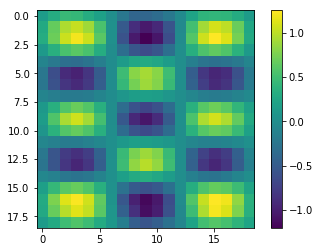

In [13]:
plt.imshow(DMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

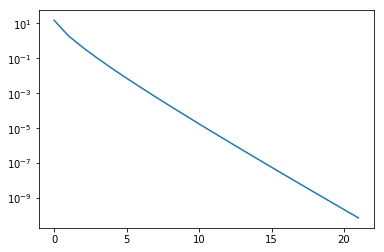

In [14]:
plt.semilogy(DMM_Res)

Radius

In [15]:
DMM_Radius = Rhonew
print('DMM_Radius = {}'.format(DMM_Radius))

DMM_Radius = 0.3504156581720339


In [16]:
wnew

array(0.79700972)

Rrestriction matrix after optimization

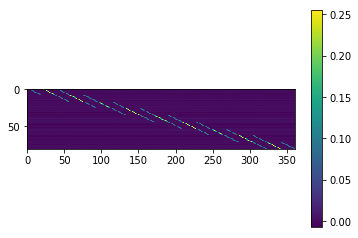

In [17]:
plt.imshow(Rnew)
plt.colorbar()

Rrestriction matrix (log(abs()) after optimization

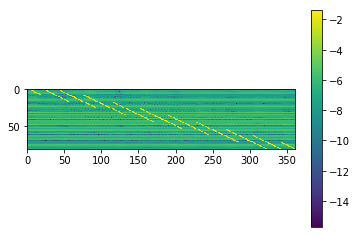

In [18]:
plt.imshow(np.log(np.abs(Rnew)))
plt.colorbar()

Basis after optimization

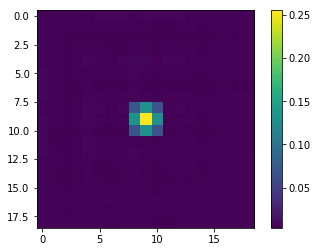

In [19]:
basis1 = Rnew[int(0.5*outputsize)][:]
basis1 = basis1.reshape([sqrtinputsize,sqrtinputsize])
plt.imshow(basis1)
plt.colorbar()

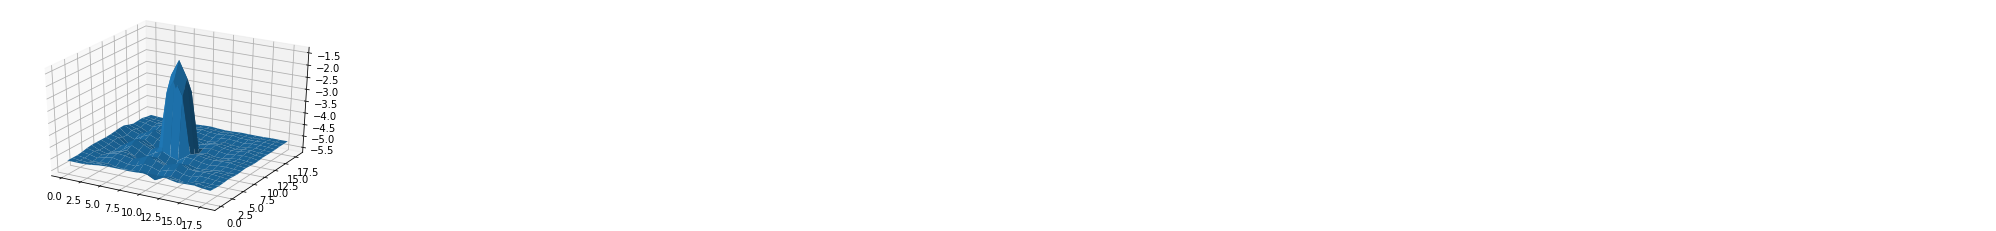

In [20]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
size=basis1.shape
Y=np.arange(0,size[0],1)     
X=np.arange(0,size[1],1)

X,Y=np.meshgrid(X,Y)    
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,np.log(abs(basis1)))
plt.show()

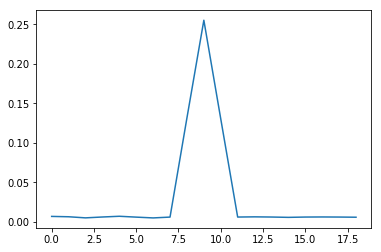

In [21]:
plt.plot(basis1[:][int(sqrtinputsize/2)])

Basis after optimization (log(abs()))

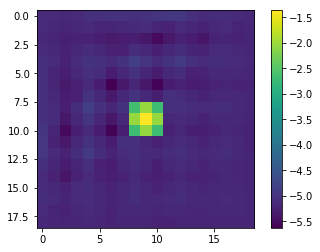

In [22]:
plt.imshow(np.log(np.abs(basis1)))
plt.colorbar()

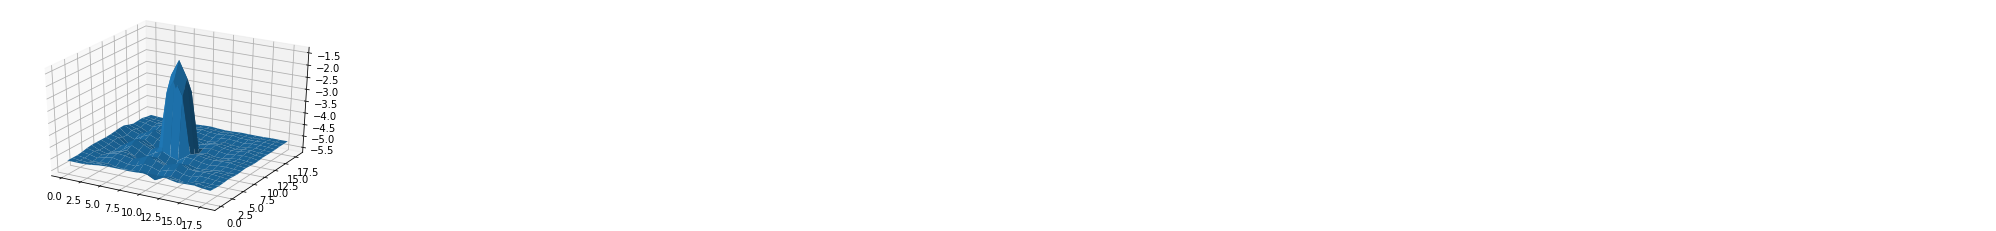

In [23]:
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,np.log(np.abs(basis1)))
plt.show()

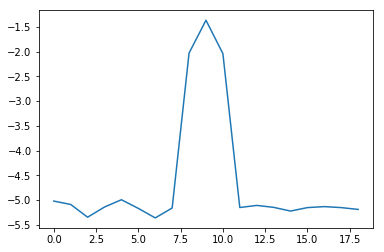

In [24]:
plt.plot(np.log(np.abs(basis1[:][int(sqrtinputsize/2)])))

FEM use basis from global DMM

Energy norm: 
5.660113520780061
L2 norm: 
0.3525391907044484
H1 norm: 
4.022251140968173
Energy norm: 
0.4617111464352926
L2 norm: 
0.7050783814088968
H1 norm: 
0.462712499097238


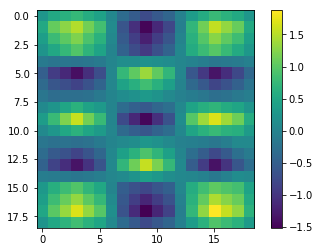

In [25]:

Anew = np.zeros([outputsize,outputsize])
[X1, Y1] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
[X2, Y2] = np.meshgrid(np.linspace(0, 1, sqrtoutputsize),np.linspace(0, 1, sqrtoutputsize))
A = a(X1,Y1)
for i in range(outputsize):
    for j in range(outputsize):
        basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
        basisj = Rnew[j][:].reshape([sqrtinputsize,sqrtinputsize])
        gxbasisi = np.gradient(basisi,axis=0)/h
        gybasisi = np.gradient(basisi,axis=1)/h
        gxbasisj = np.gradient(basisj,axis=0)/h
        gybasisj = np.gradient(basisj,axis=1)/h
        Anew[i][j]=(np.sum(A*gxbasisi*gxbasisj)+np.sum(A*gybasisi*gybasisj))*(H**2)
        
Fnew = np.zeros([outputsize,1])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    F = rightf(X1,Y1)
    Fnew[i]=np.sum(F*basisi)*(H**2)
    
UnewCoarse = np.linalg.solve(Anew,Fnew)
Unew = np.zeros([sqrtinputsize,sqrtinputsize])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    Unew = Unew + UnewCoarse[i]*basisi

plt.imshow(Unew)
plt.colorbar()

UREAL = u_real(X1,Y1).reshape(sqrtinputsize,sqrtinputsize)
deltaU = Unew - UREAL
A = a(X1,Y1)

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),A)*(h**2)))
l2norm = np.sqrt((np.sum(UREAL**2))*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))
print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))



print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum(deltaU**2))*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

In [26]:
import os
os.system("say 'The program has finished, Please check the results'")

0